# Singular Value Decomposition of Eccentric Waveforms

In [1]:
import matplotlib.pyplot as plt
plt.style.use('rcparams.mplstyle')
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import numpy as np
import time
from pycbc.types import timeseries, frequencyseries
from calcwf import gen_wf, chirp2total, shifted_f, shifted_e, gen_psd, ceiltwo, trim_wf, match_wfs, overlap_cplx_wfs, get_h

We can use singular value decomposition (SVD) to generate orthogonal harmonics describing an eccentric waveform. These harmonics are optimal in the sense that information is maximised in the fundamental, then the first harmonic, and so on.

In [2]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

## Generating training waveforms

We must first generate a basis of 'training' waveforms. The SVD will combine these to create the harmonics. We find varying the phase values of the training waveforms to have no effect on the results, and so for simplicity generate a set of waveforms uniformly spaced in mean anomaly but the same phase.

In [3]:
# Generates n training waveforms equally spaced in mean anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = +np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, training_wfs[0])
            h.resize(ceiltwo(max(len(h), len(training_wfs[0]))))
        else:
            h.resize(ceiltwo(len(h)))   
        
        training_wfs.append(h)

        # Progress bar
        print(f'\r{i+1} done out of {n}.', end='')

    return training_wfs

In [4]:
training_wfs = gen_training_wfs(f_low, e, chirp2total(chirp, q), q, 100, sample_rate, 'TEOBResumS')

100 done out of 100.

We will also whiten these waveforms with the LIGO sensitivity curve (aLIGOZeroDetHighPower) in order to appropriately weight frequencies that LIGO is sensitive to. This is important for estimating the fraction of information available in each harmonic, however equivalent results can be found using unwhitened training waveforms.

In [5]:
# Whitens waveforms
def whiten_wfs(wfs, f_low):

    # Generate psd
    psd = gen_psd(wfs[0], f_low)
    delta_f = psd.delta_f

    # Set zero values to 1 (effectively infinity)
    psd = np.array(psd)
    psd[psd==0]=1
    psd = frequencyseries.FrequencySeries(psd, delta_f)

    # Whiten each wf
    whiten = []
    for wf in wfs:
        hp = (wf.real().to_frequencyseries() / psd ** 0.5).to_timeseries()
        hc = (-wf.imag().to_frequencyseries() / psd ** 0.5).to_timeseries()
        whiten.append(hp-1j*hc)

    return whiten

In [6]:
white_training_wfs = whiten_wfs(training_wfs, f_low)

## Performing SVD

SVD is described by the following equation.

$$
\mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V^*},
$$

$\mathbf{X}$ is the complex $m \times n$ matrix consisting of the training waveforms, $\mathbf{U}$ is a complex $m \times m$ unitary matrix containing the harmonics calculated by the SVD, $\mathbf{S}$ is a $m \times n$ rectangular diagonal matrix of real positive numbers describing the relative amount of information each harmonic contains, and $\mathbf{V}$ is a complex $n\times n$ unitary matrix containing the coefficients used to express the calculated harmonics in terms of the input training waveforms.

In [7]:
# Convert training wf data to np array in right shape/form and calculate svd
start = time.time()
X = np.array(white_training_wfs).T
means = X.mean(axis=0)
stds = X.std(axis=0)
U, S, Vh = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 93.43023371696472 seconds


## Examining results

### Plotting SVD harmonics

$\mathbf{U}$ here contains the whitened harmonics, whereas we would really like to plot the unwhitened versions. We can find these simply by replacing $\mathbf{X}$ above by the unwhitened training waveforms, and solving for $\mathbf{U}$.

$$
\mathbf{U} = \mathbf{X}\mathbf{V}\mathbf{S}^{-1}
$$

In [8]:
# Calculate complex coefficients to combine unwhitened training waveforms
V = Vh.T.conj()
inv_S = 1/S
Vinv_S = np.matmul(V, np.diag(inv_S))

# Calculate unwhitened harmonics
unwhite_harms = np.matmul(np.array(training_wfs).T, Vinv_S).T

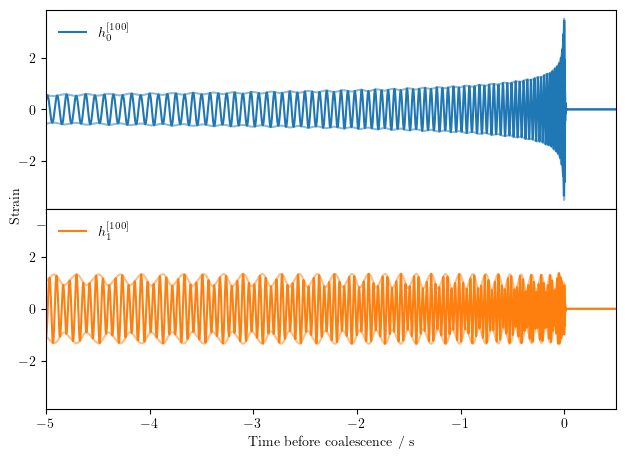

In [9]:
# Make plot of unwhitened harmonics
plt.figure(figsize=(0.98*6.4,0.98*4.8))
plt.subplot(2, 1, 1)
plt.plot(training_wfs[0].sample_times, np.real(unwhite_harms[0])*1e21, c='C0', label='$h_0^{[100]}$')
plt.plot(training_wfs[0].sample_times, abs(unwhite_harms[0])*1e21, c='C0', alpha=0.5)
plt.plot(training_wfs[0].sample_times, -abs(unwhite_harms[0])*1e21, c='C0', alpha=0.5)
plt.xlim(-5,0.5)
ylims = plt.gca().get_ylim()
plt.legend(loc='upper left', frameon=False)
plt.subplot(2, 1, 2)
plt.plot(training_wfs[0].sample_times, np.real(unwhite_harms[1])*1e21, c='C1', label='$h_1^{[100]}$')
plt.plot(training_wfs[0].sample_times, abs(unwhite_harms[1])*1e21, c='C1', alpha=0.5)
plt.plot(training_wfs[0].sample_times, -abs(unwhite_harms[1])*1e21, c='C1', alpha=0.5)
plt.ylim(ylims)
plt.xlim(-5,0.5)
plt.legend(loc='upper left', frameon=False)
plt.gcf().text(0.01, 0.55, 'Strain', va='center', rotation='vertical')
plt.xlabel('Time before coalescence / s')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('Figures/SVD100_h01.pgf')

### Relative importance

Next, we can calculate the relative importance of each harmonic from $\mathbf{S}$ using the equation:

$$
\textrm{Relative importance} = \frac{S_i^2}{\sum_i S_i^2}
$$

In [10]:
# Calculates relative importance of each harmonic
rel_imports = []
for i in range(10):
    rel_imports.append(S[i]**2/np.sum(S**2))
    print('Harmonic {} contains {:.4f}% of the total information.'.format(i, rel_imports[i]*100))

print('\n')
print('Harmonics 0 and 1 combined contain {:.4f}% of the total information.'.format((rel_imports[0]+rel_imports[1])*100))

Harmonic 0 contains 93.7043% of the total information.
Harmonic 1 contains 5.1784% of the total information.
Harmonic 2 contains 0.5617% of the total information.
Harmonic 3 contains 0.4446% of the total information.
Harmonic 4 contains 0.0572% of the total information.
Harmonic 5 contains 0.0460% of the total information.
Harmonic 6 contains 0.0054% of the total information.
Harmonic 7 contains 0.0012% of the total information.
Harmonic 8 contains 0.0005% of the total information.
Harmonic 9 contains 0.0004% of the total information.


Harmonics 0 and 1 combined contain 98.8827% of the total information.


### Building harmonics from training waveforms

Finally, we will take a look at $\mathbf{V}$ to see how to express these harmonics in terms of our basis of training waveforms.

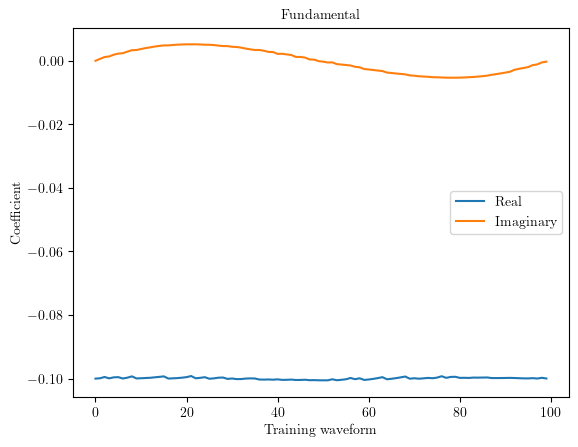

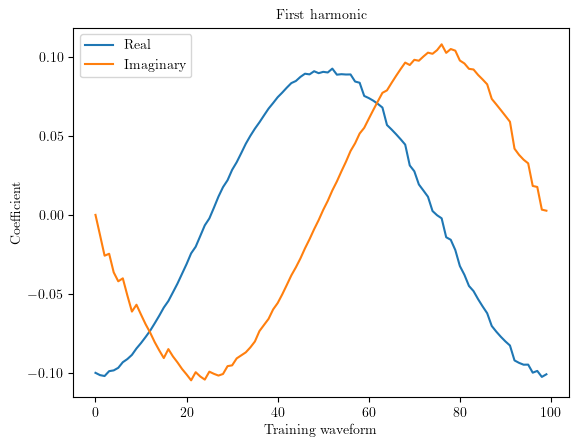

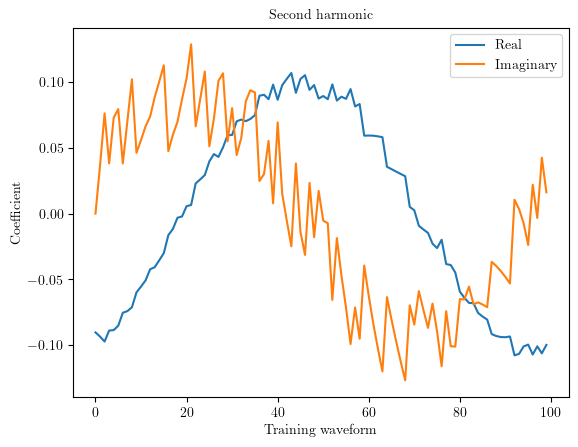

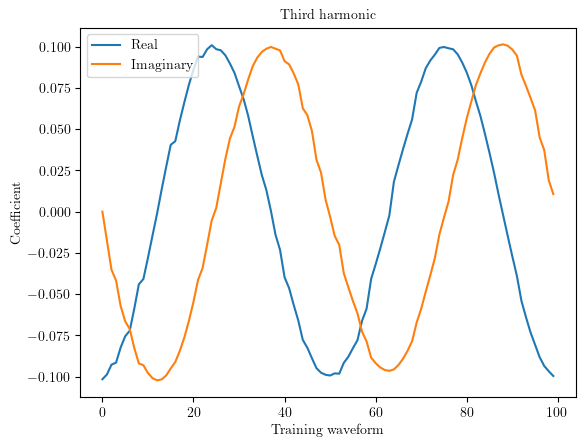

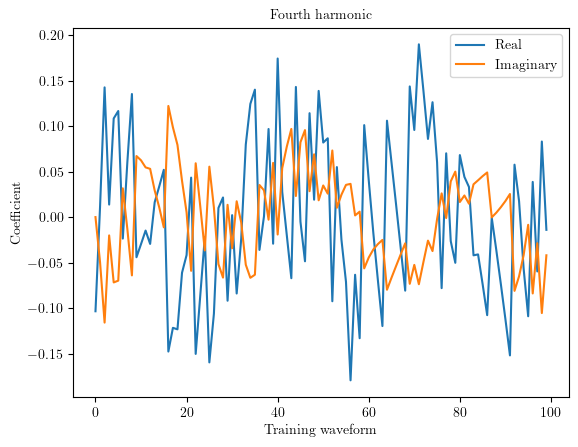

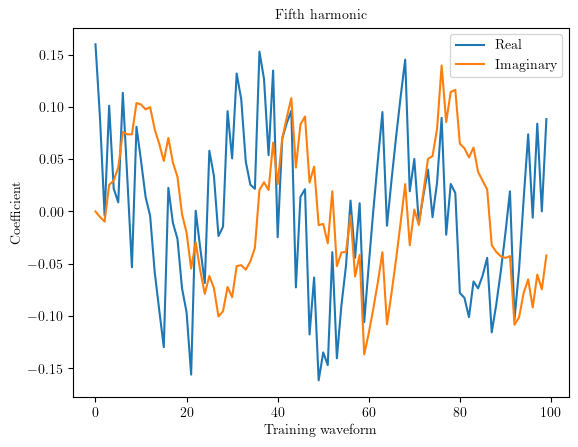

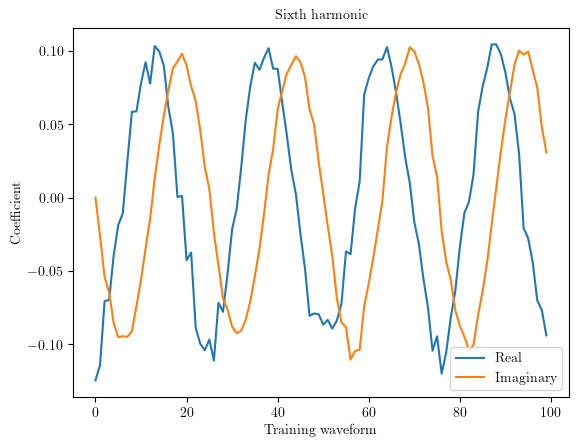

In [11]:
titles = ['Fundamental', 'First harmonic', 'Second harmonic', 'Third harmonic', 'Fourth harmonic', 'Fifth harmonic', 'Sixth harmonic']
for i in range(7):
    plt.plot(np.arange(len(V.T[i])), np.real(V.T[i]), label='Real')
    plt.plot(np.arange(len(V.T[i])), np.imag(V.T[i]), label='Imaginary')
    plt.title(titles[i])
    plt.ylabel('Coefficient')
    plt.xlabel('Training waveform')
    plt.legend()
    plt.show()

The fundamental here has a constant coefficient, meaning it is simply an average of all training waveforms.

The first harmonic exhibits a cyclic pattern, neatly shown by the plot below.

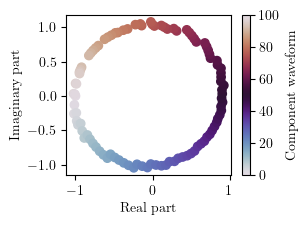

In [12]:
# Make plot
plt.figure(figsize=(0.49*6.4,0.49*4.8))
colors = np.arange(100)
plt.scatter(np.real(V.T[1])*10, np.imag(V.T[1])*10, c=colors, vmin=0, vmax=100, cmap='twilight')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.colorbar(label='Component waveform')
plt.tight_layout()
plt.savefig('Figures/SVD100_h1coeffs.pgf')

We can extend this to higher harmonics and see how to build them in the same way.

## Comparing to our waveforms

We can now compare the h0, h1, etc. waveforms we have built to the SVD harmonics found here by calculating the match between them.

In [13]:
# Convert SVD harmonics to pycbc timeseries
unwhite_harms_ts = []
for i in range(5):
    unwhite_harms_ts.append(timeseries.TimeSeries(unwhite_harms[i], 1/sample_rate, epoch=0))

# Generate our waveforms up to n=5
_, h0_2, h1_2, _, _ = get_h([1,1], f_low, e, chirp2total(chirp, q), q, sample_rate)
_, h0_3, h1_3, h2_3, _, _, _ = get_h([1,1,1], f_low, e, chirp2total(chirp, q), q, sample_rate)
_, h0_4, h1_4, h2_4, h3_4, _, _, _, _ = get_h([1,1,1,1], f_low, e, chirp2total(chirp, q), q, sample_rate)
_, h0_5, h1_5, h2_5, h3_5, h4_5, _, _, _, _, _ = get_h([1,1,1,1,1], f_low, e, chirp2total(chirp, q), q, sample_rate)
wf_2s = [h0_2, h1_2]
wf_3s = [h0_3, h1_3, h2_3]
wf_4s = [h0_4, h1_4, h2_4, h3_4]
wf_5s = [h0_5, h1_5, h2_5, h3_5, h4_5]

IndexError: invalid index to scalar variable.

In [ ]:
# Calculate matches for n=2
for i in range(2):
    match = match_wfs(unwhite_harms_ts[i], wf_2s[i], 10, True)
    print('h{}, n=2 waveform match with SVD100: {:.4f}'.format(i, match))
print('\n')

# Calculate matches for n=3
for i in range(3):
    match = match_wfs(unwhite_harms_ts[i], wf_3s[i], 10, True)
    print('h{}, n=3 waveform match with SVD100: {:.4f}'.format(i, match))
print('\n')

# Calculate matches for n=4
for i in range(4):
    match = match_wfs(unwhite_harms_ts[i], wf_4s[i], 10, True)
    print('h{}, n=4 waveform match with SVD100: {:.4f}'.format(i, match))
print('\n')

# Calculate matches for n=5
for i in range(5):
    match = match_wfs(unwhite_harms_ts[i], wf_5s[i], 10, True)
    print('h{}, n=5 waveform match with SVD100: {:.4f}'.format(i, match))

We can also make a visual comparison by overlaying our waveforms with the SVD100 versions. We will only plot envelopes of the waveforms for visual clarity, and will have to apply a scaling factor to one of the waveforms to compare them on the same scale.

In [ ]:
# Parameters
n = 4

# Generate our waveforms
all_wfs = list(get_h([1]*n, f_low, e, chirp2total(chirp, q), q, sample_rate))[1:n+1]

In [ ]:
# Make plot of each harmonic
for i in range(n):
    scaling = np.mean(np.abs(all_wfs[i]))/np.mean(np.abs(unwhite_harms_ts[i]))
    plt.plot(all_wfs[i].sample_times, np.abs(all_wfs[i]), c='C0', label=f'Our h{i}, n={n}', zorder=5)
    plt.plot(all_wfs[i].sample_times, -np.abs(all_wfs[i]), c='C0', zorder=5)
    plt.plot(all_wfs[i].sample_times, np.abs(unwhite_harms_ts[i])*scaling, c='C1', label=f'SVD100 h{i}')
    plt.plot(all_wfs[i].sample_times, -np.abs(unwhite_harms_ts[i])*scaling, c='C1')
    plt.legend()
    plt.xlim(-5,0.5)
    plt.xlabel('Time before coalescence / s')
    plt.show()

## Quick relative information

We can quickly test the relative information content of harmonics for different parameter choices by not computing the $\mathbf{U}$ and $\mathbf{V}$ matrices.

In [ ]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

In [ ]:
# Generating training wfs
training_wfs_q = gen_training_wfs(f_low, e, chirp2total(chirp, q), q, 100, sample_rate, 'TEOBResumS')
white_training_wfs_q = whiten_wfs(training_wfs_q, f_low)

In [ ]:
# Convert training wf data to np array in right shape/form and calc only S matrix in SVD
start = time.time()
X = np.array(white_training_wfs_q).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
S_q = np.linalg.svd((X-means)/stds, full_matrices=False, compute_uv=False)
end = time.time()
print(f'Time taken: {end-start} seconds')

In [ ]:
# Calculates relative importance of each harmonic
rel_imports = []
for i in range(10):
    rel_imports.append(S_q[i]**2/np.sum(S_q**2))
    print('Harmonic {} contains {:.2f}% of the total information.'.format(i, rel_imports[i]*100))

print('\n')
print('Harmonics 0 and 1 combined contain {:.2f}% of the total information.'.format((rel_imports[0]+rel_imports[1])*100))